<h1>TASK 5</h1>

<a name='000'></a>

<h2>Content</h2>

<ul>
    <ol type='1'>
    <li><a href='#001'>Environment Setup</a></li>
    <li><a href='#002'>CUDA Setup</a></li>
    <li><a href='#003'>Hyperparameter Tuning</a></li>
    <li><a href='#004'>Data Loading and Preprocessing</a></li>
    <li><a href='#005'>Metric Initialization</a></li>
    <li><a href='#006'>Model Loading</a></li>
    <li><a href='#007'>Model Training</a></li>
    <li><a href='#008'>VGG16 Loading</a></li>
    <li><a href='#009'>VGG16 Training</a></li>
    <li><a href='#010'>VGG16 Validation</a></li>
    <li><a href='#011'>ResNet50 Loading</a></li>
    <li><a href='#012'>ResNet50 Training</a></li>
    <li><a href='#013'>ResNet50 Validation</a></li>
    </ol>
</ul>

<a name='001'></a>

<h2>Environment Setup</h2>

<a href='#000'>Back</a>

Importing environment.

In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from torchsummary import summary
import argparse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

warnings.filterwarnings(action='ignore')

<a name='002'></a>

<h2>CUDA Setup</h2>

<a href='#000'>Back</a>

Since training on the `CPU` is equivalent to death, models will be trained on the `GPU`.

Initializing `cuda` and `GPU`.

In [2]:
torch.manual_seed(seed=0)

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
torch.cuda.get_device_properties(device)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 2060', major=7, minor=5, total_memory=6143MB, multi_processor_count=30)

<a name='003'></a>

<h2>Hyperparameter Tuning</h2>

<a href='#000'>Back</a>

Initializing hyperparameters and base directories.

In [4]:
parser = argparse.ArgumentParser()

parser.add_argument('--batch_size', type=int, default=16)
parser.add_argument('--shuffle', type=bool, default=True)
parser.add_argument('--num_features', type=int, default=2)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--num_epochs', type=int, default=16)
parser.add_argument('--train_path', default='data/train')
parser.add_argument('--test_path', default='data/test')
parser.add_argument('--valid_path', default='data/val')
parser.add_argument('--weights_path', default='weights/')

args, _ = parser.parse_known_args()

<a name='004'></a>

<h2>Data Loading and Preprocessing</h2>

<a href='#000'>Back</a>

Creating `transforms` object for data preprocessing. The object resizes input images to 150×150 pixels and converts arrays of pixel values to tensors.

In [5]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((150, 150)),
    torchvision.transforms.ToTensor(),
])

Loading training, test and validation datasets using `transforms` object.

In [6]:
train_dataset = torchvision.datasets.ImageFolder(args.train_path, transforms)
test_dataset = torchvision.datasets.ImageFolder(args.test_path, transforms)
valid_dataset = torchvision.datasets.ImageFolder(args.valid_path, transforms)

Packing datasets into `dataloaders` with batch size of 16 and shuffling.

In [7]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=args.batch_size,
    shuffle=args.shuffle
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=args.batch_size,
    shuffle=args.shuffle
)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=args.batch_size,
    shuffle=args.shuffle
)

Building function to visualize dataloader. Visualization of the `training dataloader` batch.

dog dog cat cat dog dog cat dog dog dog dog dog cat dog dog dog


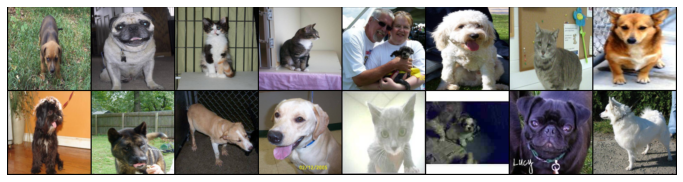

In [8]:
def plot_dataloader(dataloader):
    images, labels = dataloader
    images = torchvision.utils.make_grid(images).numpy()
    
    classes = ('cat', 'dog')
    print(' '.join(f'{classes[labels[i]]}' for i in range(args.batch_size)))
    
    plt.figure(figsize=(12, 12))
    plt.imshow(np.transpose(images, axes=(1, 2, 0)))
    plt.axis('off')
    plt.show()

plot_dataloader(next(iter(train_dataloader)))

<a name='006'></a>

<h2>Metric Initialization</h2>

<a href='#000'>Back</a>

Building function to save state of the model weights.

In [9]:
def checkpoint(model, weights_path):
    torch.save(
        {'state_dict': model.state_dict()},
        '{}{}.pth'.format(weights_path, type(model).__name__)
    )

Building function to evaluate accuracy of the model and losses on dataloader.

In [10]:
def metrics(model, dataloader, loss_function, device):
    acc_log = 0
    loss_log = 0
    num_examples = 0
    
    for index, batch in enumerate(dataloader):
        data, target = batch
        data, target = Variable(data).to(device), Variable(target).to(device)
        
        logits = model(data).squeeze(1)
        
        loss = loss_function(logits.float(), target.float())
        loss_log = loss_log + loss.item()
        
        predicted = torch.round(logits)
        acc_log = acc_log + (predicted == target).sum()
        
        num_examples = num_examples + target.size(0)
    
    return acc_log.detach().cpu().numpy() / num_examples * 100, loss_log / num_examples

Building function to plot accuracy and loss values of the model.

In [11]:
def plot_metric(acc, loss):
    figure, ax = plt.subplots(1, 2, figsize=(20, 5))
    sns.set_theme(style='whitegrid', palette='pastel')
    
    ax[0] = sns.lineplot(data=acc, ax=ax[0])
    ax[0].set(xlabel='Epoch')
    ax[0].set(ylabel='Value')
    ax[0].set_title('Test Accuracy')
    
    ax[1] = sns.lineplot(data=loss, ax=ax[1])
    ax[1].set(xlabel='Epoch')
    ax[1].set(ylabel='Value')
    ax[1].set_title('Test Loss')
    
    plt.show()

Building function to validate the model.

In [12]:
def valid_data(dataloader, model):
    data, labels = dataloader
    image = torchvision.utils.make_grid(data).numpy()
    
    classes = ('cat', 'dog')
    print('Target:')
    print(' '.join(f'{classes[labels[i]]}' for i in range(args.batch_size)))
    
    logits = torch.round(model(Variable(data).to(device)).squeeze(1)).detach().cpu().numpy()
    
    print('Prediction:')
    print(' '.join(f'{classes[int(logits[i])]}' for i in range(args.batch_size)))
    
    plt.figure(figsize=(12, 12))
    plt.imshow(np.transpose(image, axes=(1, 2, 0)))
    plt.axis('off')
    plt.show()

<a name='005'></a>

<h2>Model Loader</h2>

<a href='#000'>Back</a>

Building model `Classifier` with 3 convolutional layers and 2 fully connected layers.

In [13]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3, 3)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2)),
            
            nn.Conv2d(16, 32, kernel_size=(3, 3)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2)),
            
            nn.Conv2d(32, 64, kernel_size=(3, 3)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        self.fc = nn.Sequential(
            nn.Linear(64*17*17, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = Classifier().to(device)

Visualization of model architecture and trainable parameters.

In [14]:
summary(model, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 148, 148]             448
              ReLU-2         [-1, 16, 148, 148]               0
         MaxPool2d-3           [-1, 16, 74, 74]               0
            Conv2d-4           [-1, 32, 72, 72]           4,640
              ReLU-5           [-1, 32, 72, 72]               0
         MaxPool2d-6           [-1, 32, 36, 36]               0
            Conv2d-7           [-1, 64, 34, 34]          18,496
              ReLU-8           [-1, 64, 34, 34]               0
         MaxPool2d-9           [-1, 64, 17, 17]               0
           Linear-10                   [-1, 64]       1,183,808
             ReLU-11                   [-1, 64]               0
          Dropout-12                   [-1, 64]               0
           Linear-13                    [-1, 1]              65
          Sigmoid-14                   

Initializing optimizer and loss function.

In [15]:
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=args.lr
)

<a name='007'></a>

<h2>Model Training</h2>

<a href='#000'>Back</a>

Building function to train the model.

In [13]:
def train(model, train_dataloader, test_dataloader, device):
    acc_log = np.array([])
    loss_log = np.array([])
    error = np.inf
    
    start_time = time.time()
    
    for epoch in range(args.num_epochs):
        epoch_start = time.time()
        
        model.train()
        
        for index, batch in enumerate(train_dataloader):
            data, target = batch
            data, target = Variable(data).to(device), Variable(target).to(device)
            
            optimizer.zero_grad()
            
            logits = model(data).squeeze(1)
            
            loss = loss_function(logits.float(), target.float())
            
            loss.backward()
            optimizer.step()
        
        model.eval()
        
        with torch.no_grad():
            cur_acc, cur_loss = metrics(
                model=model,
                dataloader=test_dataloader,
                loss_function=loss_function,
                device=device
            )
            
            acc_log = np.append(acc_log, cur_acc)
            loss_log = np.append(loss_log, cur_loss)
        
        epoch_end = time.time() - epoch_start
        
        if not epoch % 5:
            print(
                'EPOCH: {}'.format(epoch),
                'ACC: {:.0f}%'.format(cur_acc),
                'LOSS: {:.4f}'.format(cur_loss),
                'TIME: {:.2f}'.format(epoch_end/60)
            )
        
        if cur_loss < error:
            error = cur_loss
            
            checkpoint(model=model, weights_path=args.weights_path)
    
    total_time = time.time() - start_time
    print('TOTAL TIME: {:.2f} min'.format(total_time/60))
    
    return acc_log, loss_log

Training `Classifier` model. Displaying model accuracy and loss values on the screen.

In [17]:
acc_log, loss_log = train(model, train_dataloader, test_dataloader, device)

EPOCH: 0 ACC: 67% LOSS: 0.0391 TIME: 0.85
EPOCH: 5 ACC: 75% LOSS: 0.0306 TIME: 0.85
EPOCH: 10 ACC: 80% LOSS: 0.0269 TIME: 0.86
EPOCH: 15 ACC: 81% LOSS: 0.0254 TIME: 0.85
TOTAL TIME: 13.82 min


Plotting accuracy and loss values of the model.

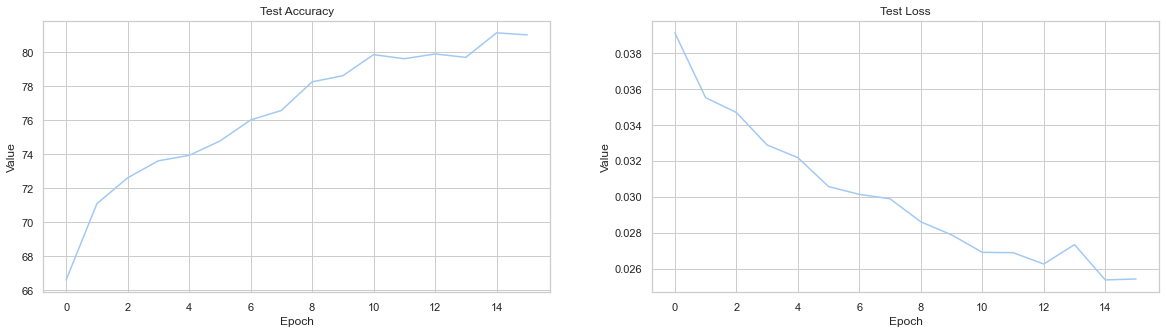

In [19]:
plot_metric(acc_log, loss_log)

<a name='008'></a>

<h2>VGG16 Loading</h2>

<a href='#000'>Back</a>

Models with `imagenet` weights are trained on normalized images.

Creating new `transforms` object with additional augmentation step, data normalization.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dog cat cat dog dog cat dog dog cat dog dog cat dog dog cat dog


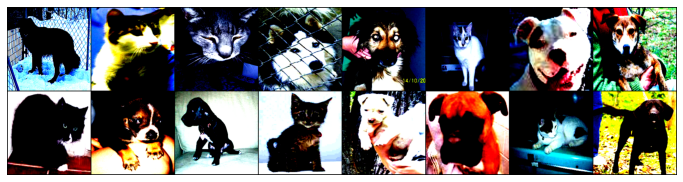

In [14]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_dataset = torchvision.datasets.ImageFolder(args.train_path, transforms)
test_dataset = torchvision.datasets.ImageFolder(args.test_path, transforms)
valid_dataset = torchvision.datasets.ImageFolder(args.valid_path, transforms)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=args.batch_size,
    shuffle=args.shuffle
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=args.batch_size,
    shuffle=args.shuffle
)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=args.batch_size,
    shuffle=args.shuffle
)

plot_dataloader(next(iter(train_dataloader)))

Loading pretrained `VGG16` model. Freezing parameter extraction layers, adding 2 fully connected layers. Model visualization.

In [15]:
transfer_model = torchvision.models.vgg16(pretrained=True)

for name, param in transfer_model.named_parameters():
    param.requires_grad = False

transfer_model.classifier = nn.Sequential(
    nn.Linear(512*7*7, 500),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(500, 1),
    nn.Sigmoid()
)

transfer_model = transfer_model.to(device)

loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(
    transfer_model.parameters(),
    lr=args.lr
)

summary(transfer_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

<a name='009'></a>

<h2>VGG16 Training</h2>

<a href='#000'>Back</a>

Training `VGG16` model. Displaying model accuracy and loss values on the screen.

In [17]:
acc_log, loss_log = train(transfer_model, train_dataloader, test_dataloader, device)

EPOCH: 0 ACC: 99% LOSS: 0.0043 TIME: 3.55
EPOCH: 5 ACC: 98% LOSS: 0.0068 TIME: 3.60
EPOCH: 10 ACC: 99% LOSS: 0.0120 TIME: 3.59
EPOCH: 15 ACC: 98% LOSS: 0.0129 TIME: 3.59
TOTAL TIME: 57.57 min


Plotting accuracy and loss values of the model.

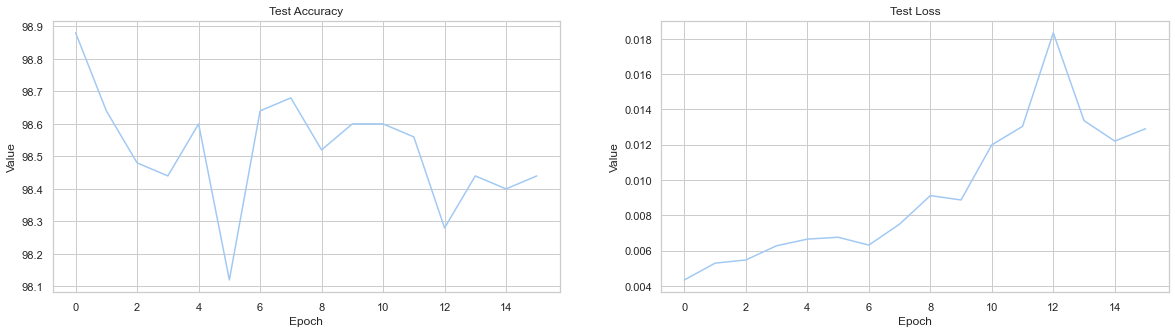

In [19]:
plot_metric(acc_log, loss_log)

<a name='010'></a>

<h2>VGG16 Validation</h2>

<a href='#000'>Back</a>

Validating `VGG16` model on validation dataloader that did not participate in training process.

Target:
cat cat cat cat cat dog cat cat cat dog cat cat dog dog cat dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction:
cat cat cat cat cat dog cat cat cat dog cat cat dog dog cat dog


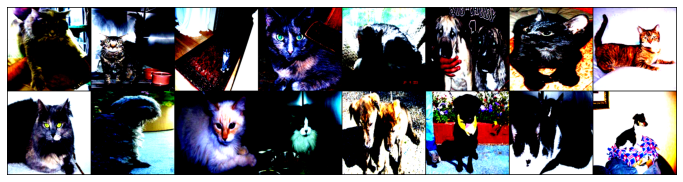

In [20]:
valid_data(next(iter(valid_dataloader)), transfer_model)

<a name='011'></a>

<h2>ResNet50 Loading</h2>

<a href='#000'>Back</a>

Loading pretrained `ResNet50` model. Freezing parameter extraction layers, adding 2 fully connected layers. Model visualization.

In [21]:
transfer_model = torchvision.models.resnet50(pretrained=True)

for name, param in transfer_model.named_parameters():
    param.requires_grad = False

transfer_model.fc = nn.Sequential(
    nn.Linear(transfer_model.fc.in_features, 500),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(500, 1),
    nn.Sigmoid())

transfer_model = transfer_model.to(device)

loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(
    transfer_model.parameters(),
    lr=args.lr
)

summary(transfer_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

<a name='012'></a>

<h2>ResNet50 Training</h2>

<a href='#000'>Back</a>

Training `ResNet50` model. Displaying model accuracy and loss values on the screen.

In [22]:
acc_log, loss_log = train(transfer_model, train_dataloader, test_dataloader, device)

EPOCH: 0 ACC: 98% LOSS: 0.0030 TIME: 1.65
EPOCH: 5 ACC: 98% LOSS: 0.0036 TIME: 1.68
EPOCH: 10 ACC: 98% LOSS: 0.0026 TIME: 1.68
EPOCH: 15 ACC: 98% LOSS: 0.0026 TIME: 1.69
TOTAL TIME: 26.85 min


Plotting accuracy and loss values of the model.

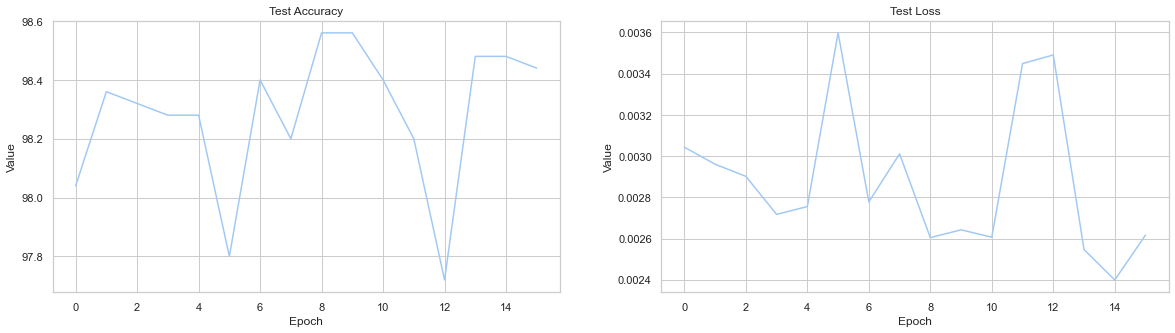

In [23]:
plot_metric(acc_log, loss_log)

<a name='013'></a>

<h2>ResNet50 Validation</h2>

<a href='#000'>Back</a>

Validating `ResNet50` model on validation dataloader that did not participate in training process.

Target:
dog dog cat dog dog dog dog dog cat dog cat dog cat cat cat cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction:
dog dog cat dog dog dog dog dog cat dog cat dog cat cat cat cat


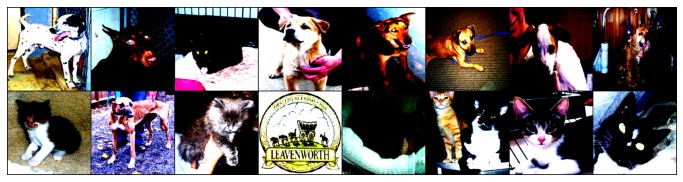

In [25]:
valid_data(next(iter(valid_dataloader)), transfer_model)